# Train FASHION-MNIST dataset using neural network with fully connected layers

In [1]:
%matplotlib inline

import numpy as np
import torch

import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST
dataset_root = "./data/fashion_pt" 
Dataset = FashionMNIST

## Data

In [2]:
# Download and prepare data

transform_train = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

trainset = Dataset(dataset_root, download=True, train=True, transform=transform_train)
testset = Dataset(dataset_root, download=True, train=False, transform=transform_test)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(classes)

### Data loader

In [3]:
# Create data loader

batch_size = 16
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

Images size: (16, 1, 28, 28)
Single squeezed image: (28, 28)
Label: tensor(6)


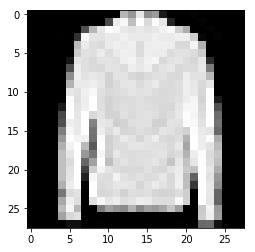

In [4]:
# Show some examples using iterator

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

idx = np.random.choice(batch_size)
plt.imshow(np.squeeze(images[idx]), cmap='gray')

print('Images size: ' + str(images.shape))
print('Single squeezed image: ' + str(np.squeeze(images[idx]).shape))
print('Label: ' + str(labels[idx]))

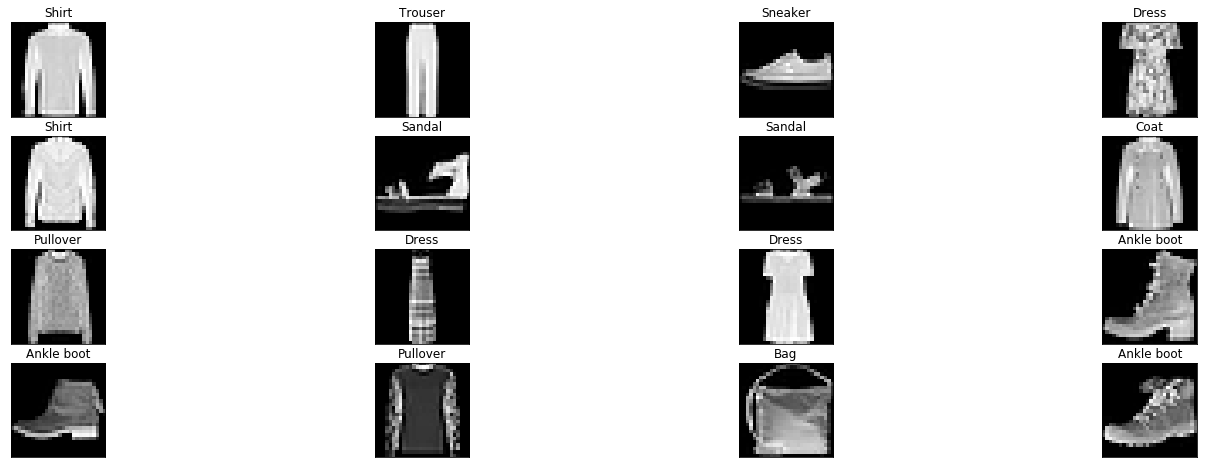

In [5]:
# Show a full batch

fig = plt.figure(figsize=(25, 8))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

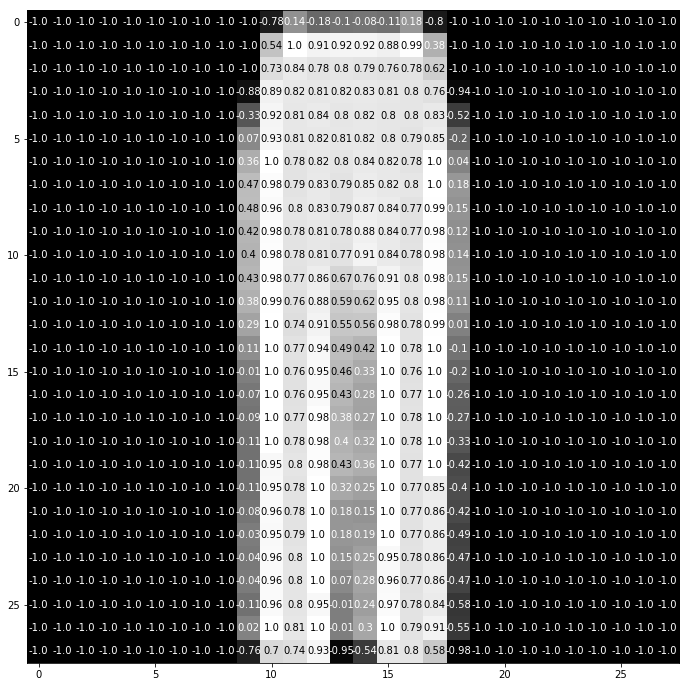

In [6]:
# Show image with pixel values

# Getting an image
idx = np.random.choice(batch_size)
img = np.squeeze(images[idx])

# Show image
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5

# Display pixel values
for x in range(width):
    for y in range(height):
        val = img[x][y].round(2) if img[x][y] !=0 else 0 # 2 decimal rounding
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black') # Just to be able to see the number

## Let's define Neural Network with pytorch

In [7]:
from torch import nn
from torch import optim
import torch.nn.functional as F

In [8]:
input_dim = 28 * 28
num_classes = len(classes)

class LinearNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.drop1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(256, 64)
        self.drop2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = x.view(x.size(0), -1) #flatten the image 
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = self.fc3(x)
        return x
        
model = LinearNN()
model

LinearNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop1): Dropout(p=0.2)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (drop2): Dropout(p=0.2)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [9]:
#Define learning rate, loss function and optimizer

learning_rate = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Let's see how it performs before training

In [10]:
def eval_model_on_test_set():
    correct = 0
    total = 0
    total_loss = torch.zeros(1)
    model.eval()

    for images, labels in test_loader:

        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1) # outputs -> value, index

        total += labels.size(0)
        correct += (predicted == labels).sum()

    accuracy = 100.0 * correct.item() / total
    print('Accuracy: {}, Test Loss: {}'.format(accuracy, (total_loss * batch_size / total).item()))

eval_model_on_test_set()    

Accuracy: 4.67, Test Loss: 2.3097987174987793


## Let's train it

In [11]:
def train(n_epochs):
    model.train()
    
    loss_over_time = [] # to track the loss as the network trains
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data # inputs.size() -> torch.Size([16, 1, 28, 28])

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = model(inputs)

            # calculate the loss using CrossEntropyLoss as defined
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if batch_i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0
                eval_model_on_test_set()
                model.train()

    print('Finished Training')
    return loss_over_time


In [12]:
n_epochs = 10 # start small to see if your model works, initially

# call train and record the loss over time
training_loss = train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 1.0067845293432474
Accuracy: 77.36, Test Loss: 0.6247162222862244
Epoch: 1, Batch: 2000, Avg. Loss: 0.6214365583956242
Accuracy: 80.34, Test Loss: 0.5393552184104919
Epoch: 1, Batch: 3000, Avg. Loss: 0.5452922384142875
Accuracy: 82.12, Test Loss: 0.49401387572288513
Epoch: 2, Batch: 1000, Avg. Loss: 0.4863224763721228
Accuracy: 83.35, Test Loss: 0.46307042241096497
Epoch: 2, Batch: 2000, Avg. Loss: 0.4703699745684862
Accuracy: 83.9, Test Loss: 0.4497371017932892
Epoch: 2, Batch: 3000, Avg. Loss: 0.45222376170009376
Accuracy: 83.9, Test Loss: 0.43817222118377686
Epoch: 3, Batch: 1000, Avg. Loss: 0.42571337905526163
Accuracy: 84.37, Test Loss: 0.4282941520214081
Epoch: 3, Batch: 2000, Avg. Loss: 0.42504434253275397
Accuracy: 85.0, Test Loss: 0.41191619634628296
Epoch: 3, Batch: 3000, Avg. Loss: 0.40708965573459865
Accuracy: 85.26, Test Loss: 0.41179805994033813
Epoch: 4, Batch: 1000, Avg. Loss: 0.40361893278360367
Accuracy: 85.22, Test Loss: 0.4035508334

In [13]:
learning_rate = 0.00003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
n_epochs = 10 

# call train and record the loss over time
training_loss = train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 0.29414148366451265
Accuracy: 88.08, Test Loss: 0.3333108425140381
Epoch: 1, Batch: 2000, Avg. Loss: 0.28486111463606356
Accuracy: 88.22, Test Loss: 0.33047059178352356
Epoch: 1, Batch: 3000, Avg. Loss: 0.2795469289347529
Accuracy: 88.12, Test Loss: 0.3299137353897095
Epoch: 2, Batch: 1000, Avg. Loss: 0.2749342095181346
Accuracy: 88.28, Test Loss: 0.32860228419303894
Epoch: 2, Batch: 2000, Avg. Loss: 0.2783181679099798
Accuracy: 88.21, Test Loss: 0.32894566655158997
Epoch: 2, Batch: 3000, Avg. Loss: 0.28635135059058664
Accuracy: 88.08, Test Loss: 0.32613497972488403
Epoch: 3, Batch: 1000, Avg. Loss: 0.27519669906795025
Accuracy: 88.22, Test Loss: 0.3269098997116089
Epoch: 3, Batch: 2000, Avg. Loss: 0.2782906949669123
Accuracy: 88.28, Test Loss: 0.3293696641921997
Epoch: 3, Batch: 3000, Avg. Loss: 0.2758993681743741
Accuracy: 88.47, Test Loss: 0.32489725947380066
Epoch: 4, Batch: 1000, Avg. Loss: 0.285194361589849
Accuracy: 88.36, Test Loss: 0.323892980

## Let's test it

In [15]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

# set the module to evaluation mode
model.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = model(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(labels[0]):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(num_classes):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.315496

Test Accuracy of T-shirt/top: 82% (176/213)
Test Accuracy of Trouser: 96% (274/283)
Test Accuracy of Pullover: 83% (212/254)
Test Accuracy of Dress: 87% (239/274)
Test Accuracy of  Coat: 81% (244/298)
Test Accuracy of Sandal: 95% (261/273)
Test Accuracy of Shirt: 67% (195/290)
Test Accuracy of Sneaker: 94% (293/309)
Test Accuracy of   Bag: 97% (272/278)
Test Accuracy of Ankle boot: 97% (266/274)

Test Accuracy (Overall): 88% (2432/2746)


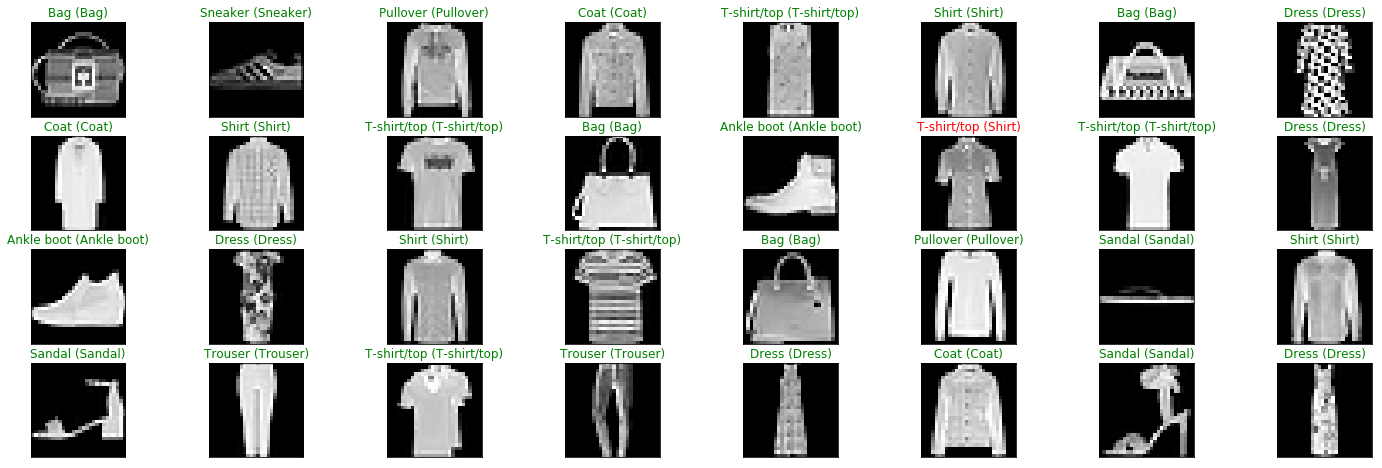

In [16]:
# Show a batch of images and its results
batch_size=32
test_loader2 = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

# obtain one batch of test images
dataiter = iter(test_loader2)
images, labels = dataiter.next()

# get predictions
outputs = model(images)
preds = np.squeeze(outputs.data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 8))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [17]:
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix

batch_size=10000
test_loader3 = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=True)
dataiter = iter(test_loader3)
images, labels = dataiter.next()
outputs = model(images)
array  = confusion_matrix(labels, np.squeeze(outputs.data.max(1, keepdim=True)[1].numpy()))

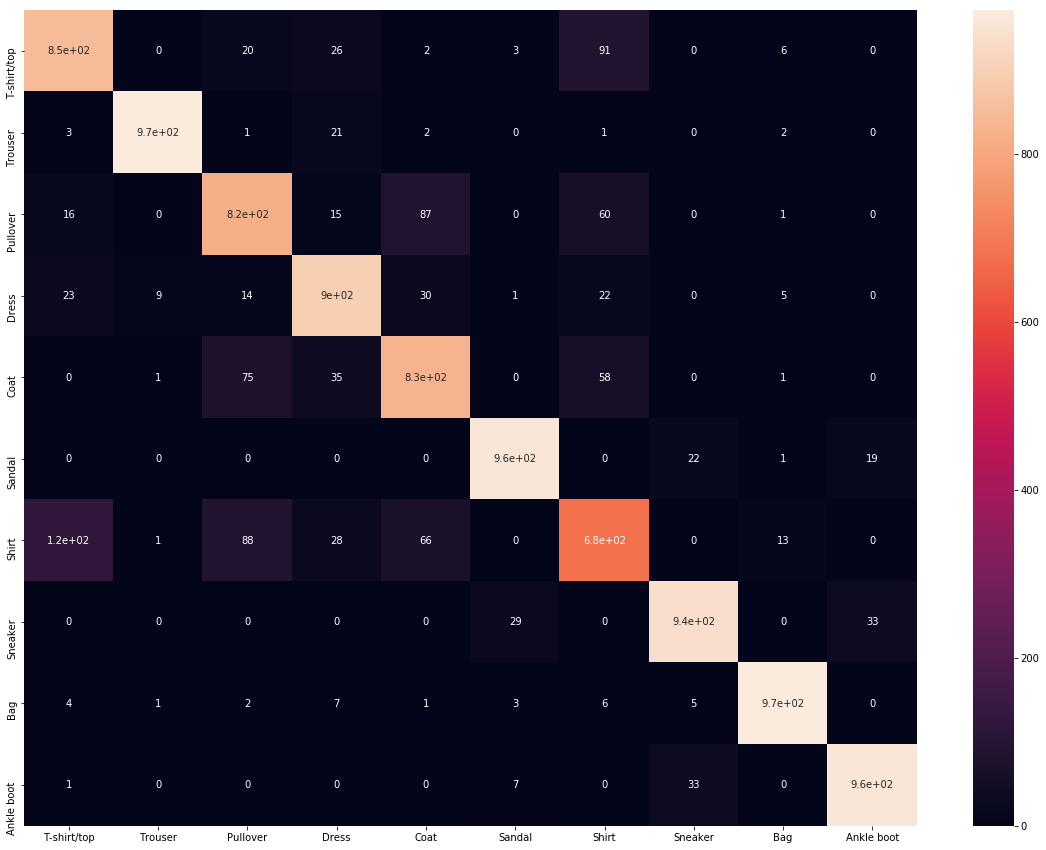

In [18]:
# Show confusion matrix

import pandas as pd
import seaborn as sn

df_cm = pd.DataFrame(array, index = [i for i in classes], columns = [i for i in classes ])
plt.figure(figsize = (20,15))
sn.heatmap(df_cm, annot=True)

## Competition

Who can get the best accuracy on the test set?

You can try to change your model arch using:
* More linear layers (https://pytorch.org/docs/stable/nn.html#linear-layers)
+ Activation functions like Relu (https://pytorch.org/docs/stable/nn.html#torch.nn.ReLU) or Tanh (https://pytorch.org/docs/stable/nn.html#torch.nn.Tanh)
* Dropout(https://pytorch.org/docs/stable/nn.html#dropout-layers)

## Learnings

https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607

* Apply same transforms on train and test data 
* Relu does not make sense on last linear layer
* Use model.train() // model.eval() to make sure dropout is not applied on test data
* Use appropiate learning rates
* NOT use softmax as nn.CrossEntropyLoss already includes logSoftMax